# Profile of toron states

In [1]:
# %%
import sys
import plot_tools as pt
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib as mpl
import numpy as np
from skimage import measure

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
import scipy.interpolate as si
from matplotlib.colors import LightSource
import oommfpy.tools as ot

from pathlib import Path
import glob

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
import fidimag as fd
from fidimag.common import CuboidMesh
from fidimag.atomistic import Sim

# Simulation

In [3]:
FIELD = 360
nx, ny, nz = 30, 30, 30
dx, dy, dz = 1, 1, 1
mesh = CuboidMesh(nx=nx, ny=ny, nz=nz,
                  dx=dx, dy=dy, dz=dz,
                  x0=-nx * 0.5, y0=-ny * 0.5, z0=-nz * 0.5,
                  unit_length=1.,
                  periodicity=(True, True, False)
                  )

sim_name = 'energy'
sim = Sim(mesh, name=sim_name, integrator='sundials_openmp')

sim.mu_s = 1
sim.add(fd.atomistic.Exchange(1))
sim.add(fd.atomistic.DMI(0.727, dmi_type='bulk'))
sim.add(fd.atomistic.Zeeman((0.0, 0.0, FIELD * 1e-3)), save_field=True)
# kc = -0.05
# if np.abs(kc) > 0.0:
#     sim.add(fd.atomistic.CubicAnisotropy(kc))

x, y, z = mesh.coordinates[:, 0], mesh.coordinates[:, 1], mesh.coordinates[:, 2]
xs, ys, zs = np.unique(x), np.unique(y), np.unique(z)

exchange = sim.get_interaction('Exchange')
dmi = sim.get_interaction('DMI')
zeeman = sim.get_interaction('Zeeman')

Number of threads (CVODE) = 8


In [4]:
state = np.load('sims/fidimag/equilibrium_states/D727e-3_GNEBM_LOCAL_MIN/npys/'
                'toron_two-bobbers_WEAK/m_toron_two-bobbers_WEAK_Bz_000360.npy')
sim.set_m(state)
sim.compute_effective_field(t=0)
ze = zeeman.compute_energy()

# Compute the total energy in xy planes. We will substract the energy of
# the conical state from these to obtain the energy of the torons/bobbers
# as a function of z
edens_bt = np.zeros(len(zs))
for i, z_coord in enumerate(zs):
    ftr = z == z_coord
    edens_plane = np.sum(exchange.energy[ftr] + dmi.energy[ftr] + zeeman.energy[ftr])
    edens_bt[i] = edens_plane

# ftr = np.logical_and(x == -0.5, y == -0.5)
spin_bobber_torons = np.copy(sim.spin.reshape(-1, 3))
tot_energy_bobber_torons = exchange.energy + dmi.energy + zeeman.energy

In [5]:
state = np.load('sims/fidimag/equilibrium_states/D727e-3/npys/one_dim_mod/m_one_dim_mod_Bz_000360.npy')
sim.set_m(state)
sim.compute_effective_field(t=0)
ze = zeeman.compute_energy()

edens_con = np.zeros(len(zs))
for i, z_coord in enumerate(zs):
    # ftr = np.logical_and(x == -0.5, y == -0.5)
    ftr = z == z_coord
    edens_plane = np.sum(exchange.energy[ftr] + dmi.energy[ftr] + zeeman.energy[ftr])
    edens_con[i] = edens_plane

spin_conical = np.copy(sim.spin.reshape(-1, 3))
tot_energy_conical = exchange.energy + dmi.energy + zeeman.energy

In [117]:
spin_bobber_torons.shape

(27000, 3)

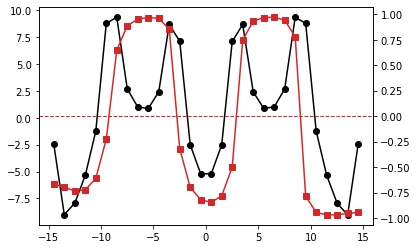

In [118]:
f, ax = plt.subplots()

# Energy with respect to the conical state
ax.plot(zs, edens_bt - edens_con, 'o-k')

ax2 = ax.twinx()
ftr = np.logical_and(x == -0.5, y == -1.5)
ax2.plot(z[ftr], spin_bobber_torons[:, 2][ftr], 's-C3')
ax2.axhline(y=0, color='C3', lw=1, ls='--')

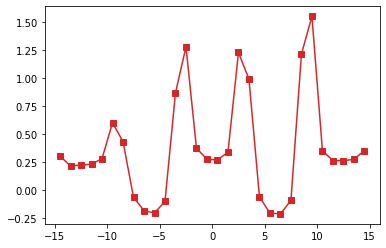

In [122]:
ftr = np.logical_and(x == -0.5, y == -1.5)
plt.plot(z[ftr], (tot_energy_bobber_torons - tot_energy_conical)[ftr], 's-C3')

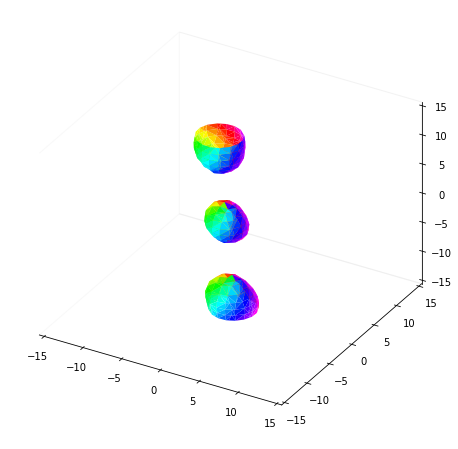

In [119]:
f = plt.figure(figsize=(8, 8))
ax = f.add_subplot(1, 1, 1, projection='3d', proj_type='ortho')

vol_mz = spin_bobber_torons[:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))

verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )
# print(p._facecolors3d.shape)
vol_mx = spin_bobber_torons[:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spin_bobber_torons[:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spin_bobber_torons[:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

# ax.add_collection3d(col)

ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_zlim([-15, 15])

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# plt.savefig('sk_tube_Bz400_no-anis_relaxed.pdf', bbox_inches='tight')

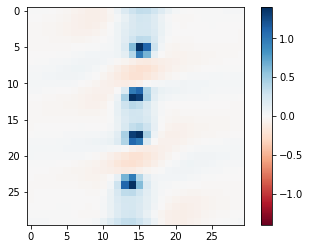

In [120]:
ftr = y == -0.5
E_dens = tot_energy_bobber_torons[ftr] - tot_energy_conical[ftr]
E_dens.shape = (-1, len(zs))
plt.imshow(E_dens, cmap='RdBu', vmin=-1.4, vmax=1.4)
plt.colorbar()

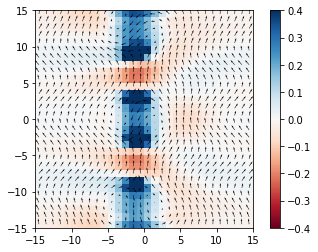

In [140]:
ftr = x == 0.5
E_dens = tot_energy_bobber_torons[ftr] - tot_energy_conical[ftr]
E_dens.shape = (-1, len(zs))
plt.imshow(E_dens, cmap='RdBu', 
           vmin=-.4, vmax=.4, 
           extent=[-15, 15, -15, 15])
plt.colorbar()

plt.quiver(y[ftr], z[ftr], 
           spin_bobber_torons[:, 1][ftr],
           spin_bobber_torons[:, 2][ftr],
           scale=35)

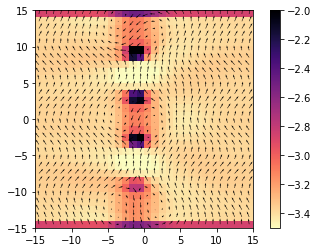

In [136]:
ftr = x == 0.5
E_dens = tot_energy_bobber_torons[ftr]
E_dens.shape = (-1, len(zs))
plt.imshow(E_dens, 
           cmap='magma_r', 
           vmin=-3.5, vmax=-2, 
           extent=[-15, 15, -15, 15])
plt.colorbar()

plt.quiver(y[ftr], z[ftr], 
           spin_bobber_torons[:, 1][ftr],
           spin_bobber_torons[:, 2][ftr],
           scale=35)

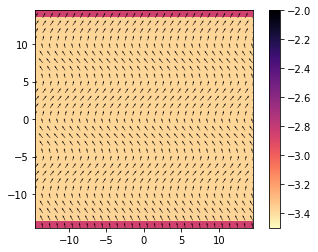

In [137]:
ftr = x == 0.5
E_dens = tot_energy_conical[ftr]
E_dens.shape = (-1, len(zs))
plt.imshow(E_dens, 
           cmap='magma_r', 
           vmin=-3.5, vmax=-2, 
           extent=[-14.5, 14.5, -14.5, 14.5])
plt.colorbar()

plt.quiver(y[ftr], z[ftr], 
           spin_conical[:, 1][ftr],
           spin_conical[:, 2][ftr],
           scale=35)